# Importing Libraries

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
from patchify import patchify

import cv2
import imageio.v2 as imageio
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, BatchNormalization, Dropout, Lambda

2024-06-19 01:01:17.854743: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 01:01:17.877212: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 01:01:17.966760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 01:01:19.330846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
from keras import backend as K

# Preprocessing Images

In [8]:
# Selecting the root dataset folder and it respective name
root_dataset_folder = r'../deep-learning-imagery-classification/data'

In [9]:
for path, subdirs, files in os.walk(os.path.join(root_dataset_folder)):
    dir_name = path.split(os.path.sep)[-1]
    print(dir_name)
    
    if dir_name == 'images': # masks
        images = os.listdir(path)
        # print(images)
        for i, image_name in enumerate(images): 
            if (image_name.endswith('.jpg')): # .png
                print(image_name)   

data
Tile 7
images
image_part_004.jpg
image_part_007.jpg
image_part_008.jpg
image_part_005.jpg
image_part_001.jpg
image_part_002.jpg
image_part_009.jpg
image_part_006.jpg
image_part_003.jpg
masks
Tile 8
images
image_part_004.jpg
image_part_007.jpg
image_part_008.jpg
image_part_005.jpg
image_part_001.jpg
image_part_002.jpg
image_part_009.jpg
image_part_006.jpg
image_part_003.jpg
masks
Tile 4
images
image_part_004.jpg
image_part_007.jpg
image_part_008.jpg
image_part_005.jpg
image_part_001.jpg
image_part_002.jpg
image_part_009.jpg
image_part_006.jpg
image_part_003.jpg
masks
Tile 1
images
image_part_004.jpg
image_part_007.jpg
image_part_008.jpg
image_part_005.jpg
image_part_001.jpg
image_part_002.jpg
image_part_009.jpg
image_part_006.jpg
image_part_003.jpg
masks
Tile 5
images
image_part_004.jpg
image_part_007.jpg
image_part_008.jpg
image_part_005.jpg
image_part_001.jpg
image_part_002.jpg
image_part_009.jpg
image_part_006.jpg
image_part_003.jpg
masks
Tile 3
images
image_part_004.jpg
image_p

In [10]:
minmaxscaler = MinMaxScaler()
image_patch_size = 256

image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,9):
      image = imageio.imread(f'{root_dataset_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}')
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [11]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
print(len(image_dataset))
print(len(mask_dataset))

840
840


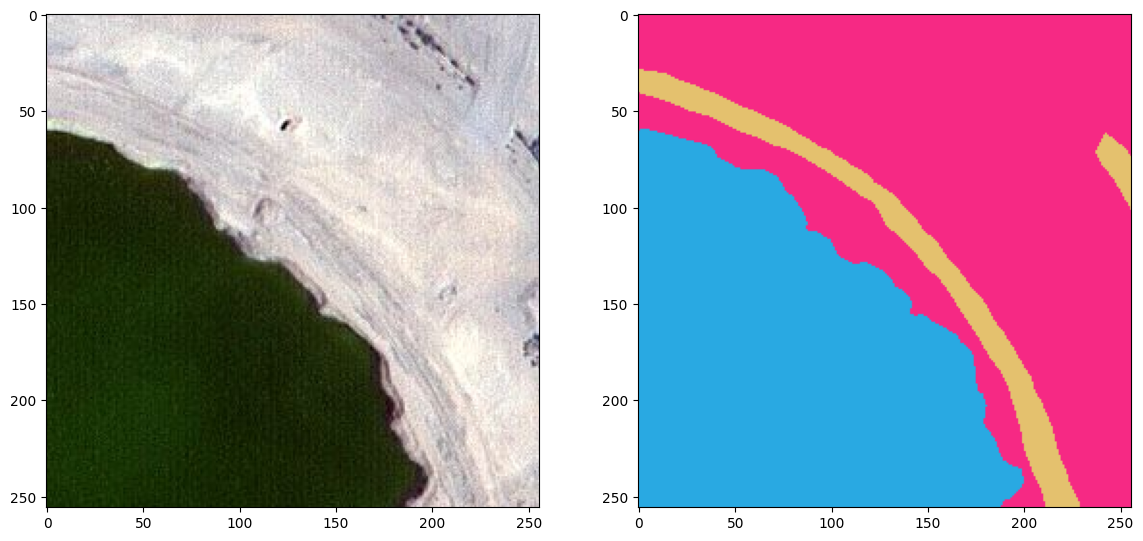

In [13]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.show()

In [14]:
class_building = '#98103C'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#F62984'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#E4C16E'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#3ADDFE'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#29A9E2'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[152  16  60]
[246  41 132]
[228 193 110]
[ 58 221 254]
[ 41 169 226]
[155 155 155]


In [15]:
label = individual_patched_mask

In [16]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    #print(label_segment)
    label_segment = label_segment[:,:,0]
    #print(label_segment)
    return label_segment

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [18]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [19]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [20]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


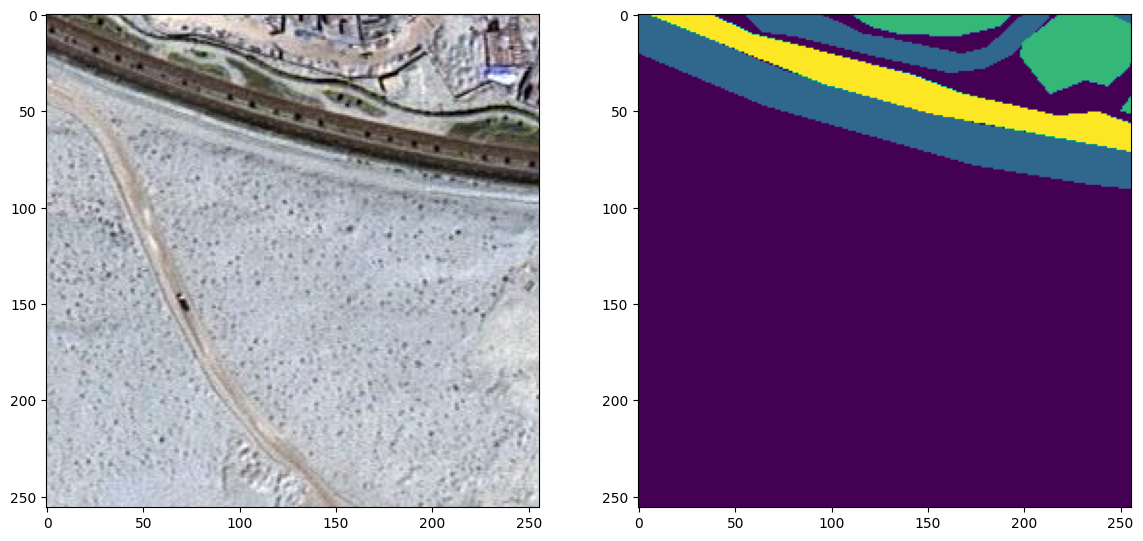

In [21]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:, :, 0])
plt.show()

In [22]:
total_classes = len(np.unique(labels))
total_classes

6

In [23]:
labels_categorical_dataset = to_categorical(labels, num_classes = total_classes)

In [24]:
master_training_dataset = image_dataset

In [25]:
labels_categorical_dataset.shape

(840, 256, 256, 6)

In [26]:
master_training_dataset.shape

(840, 256, 256, 3)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size = 0.15, random_state = 42)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(714, 256, 256, 3)
(714, 256, 256, 6)
(126, 256, 256, 3)
(126, 256, 256, 6)


In [29]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

# Deep Learning

In [30]:
from tensorflow.keras.backend import flatten, sum

In [31]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = flatten(y_true)
    y_pred_flatten = flatten(y_pred)
    intersection = sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (sum(y_true_flatten) + sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [33]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))
    source_input = inputs
    
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [34]:
metrics = ['accuracy', jaccard_coef]

In [35]:
def get_deep_learning_model():
    return multi_unet_model(n_classes = total_classes,
                            image_height = image_height,
                            image_width = image_width,
                            image_channels = image_channels)

In [36]:
model = get_deep_learning_model()

In [37]:
model.get_config()
model.save('../deep-learning-imagery-classification/model.keras')

In [38]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [39]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [40]:
model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=16, 
                          verbose=1, 
                          epochs=10, 
                          validation_data = (X_test, y_test), 
                          shuffle=False)

2024-06-19 01:04:11.872915: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 561512448 exceeds 10% of free system memory.


Epoch 1/10


2024-06-19 01:04:16.275423: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1123024896 exceeds 10% of free system memory.
2024-06-19 01:04:22.912990: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-06-19 01:04:22.997092: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-06-19 01:04:22.997124: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


45/45 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.3645 - jaccard_coef: 0.1784 - loss: 1.0179 - val_accuracy: 0.6784 - val_jaccard_coef: 0.3087 - val_loss: 0.9892
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.6333 - jaccard_coef: 0.3251 - loss: 0.9892 - val_accuracy: 0.7145 - val_jaccard_coef: 0.3602 - val_loss: 0.9792
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6831 - jaccard_coef: 0.4043 - loss: 0.9723 - val_accuracy: 0.7392 - val_jaccard_coef: 0.4650 - val_loss: 0.9649
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.7134 - jaccard_coef: 0.4476 - loss: 0.9625 - val_accuracy: 0.7694 - val_jaccard_coef: 0.4792 - val_loss: 0.9539
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.7341 - jaccard_coef: 0.4656 - loss: 0.9556 - val_accuracy: 0.7508 - val_jaccard_coef: 0.4801 - val_loss: 0.9519
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7357 - jaccard_coef: 0.4825 - loss: 0.9528 - val_accuracy: 0.

In [43]:
history_a = model_history

In [44]:
history_a.history

{'accuracy': [0.48840951919555664,
  0.6411702632904053,
  0.6889746785163879,
  0.7178096175193787,
  0.7328681945800781,
  0.7360662221908569,
  0.7415841817855835,
  0.7520594000816345,
  0.7609959244728088,
  0.767250120639801],
 'jaccard_coef': [0.23517021536827087,
  0.3315437436103821,
  0.42046448588371277,
  0.4503684937953949,
  0.4708244800567627,
  0.4849737882614136,
  0.494718462228775,
  0.515480101108551,
  0.5307995080947876,
  0.5413866639137268],
 'loss': [1.0043855905532837,
  0.9873971939086914,
  0.9690797924995422,
  0.9612200260162354,
  0.9558116793632507,
  0.9533520340919495,
  0.9513909816741943,
  0.9466831684112549,
  0.9437037706375122,
  0.9419040083885193],
 'val_accuracy': [0.6784468293190002,
  0.7145401239395142,
  0.7391530871391296,
  0.7693609595298767,
  0.7507636547088623,
  0.7519945502281189,
  0.7624158263206482,
  0.7470238208770752,
  0.7690067887306213,
  0.7813754677772522],
 'val_jaccard_coef': [0.3086913228034973,
  0.3602018654346466,


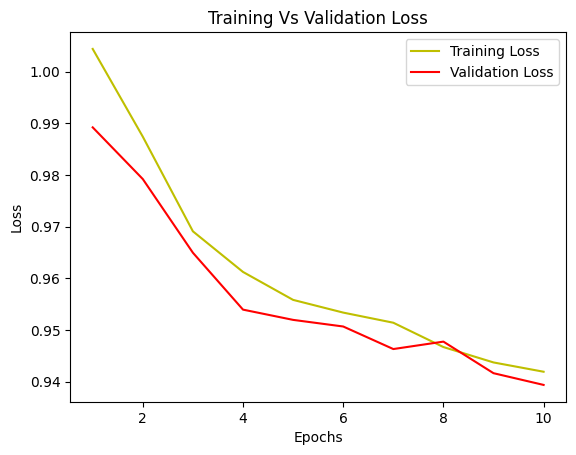

In [45]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

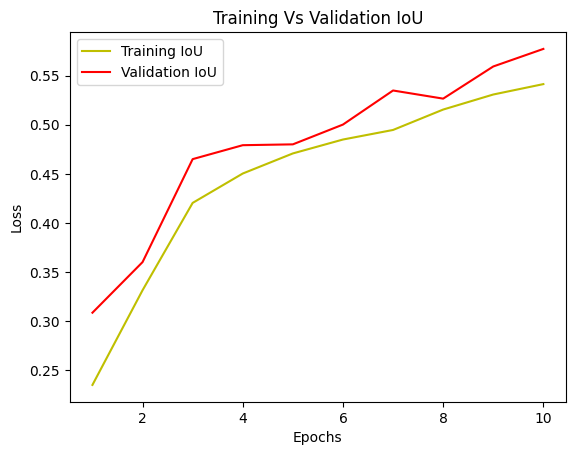

In [46]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 45}

In [48]:
y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [49]:
len(y_pred)

126

In [50]:
y_pred

array([[[[6.23695105e-02, 6.35739744e-01, 1.64411351e-01,
          4.96724956e-02, 6.36896193e-02, 2.41171494e-02],
         [1.84448231e-02, 6.99053943e-01, 1.86210558e-01,
          4.01721559e-02, 4.10049744e-02, 1.51135353e-02],
         [1.19335083e-02, 6.56858385e-01, 2.65221953e-01,
          3.12855095e-02, 2.62202863e-02, 8.48033093e-03],
         ...,
         [3.83584462e-02, 5.99266469e-01, 2.70957738e-01,
          1.74413696e-02, 6.16405830e-02, 1.23354020e-02],
         [4.40356210e-02, 5.63303709e-01, 3.01256329e-01,
          2.26067100e-02, 5.26835136e-02, 1.61139723e-02],
         [6.02309443e-02, 4.00255978e-01, 3.58462691e-01,
          5.40937968e-02, 8.73949751e-02, 3.95613760e-02]],

        [[1.63334329e-02, 8.37805986e-01, 8.22668448e-02,
          3.08887735e-02, 2.40146816e-02, 8.69026221e-03],
         [3.52281309e-03, 9.00183499e-01, 7.18720704e-02,
          1.59881059e-02, 5.59031777e-03, 2.84307660e-03],
         [1.34193804e-03, 8.64982605e-01, 1.1797

In [51]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [52]:
len(y_pred_argmax)

126

In [53]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 2],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 2, 2, ..., 0, 0, 0],
        [1, 1, 2, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 2],
        [1, 1, 2, ..., 1, 1, 2],
        [1, 1, 1, ..., 4, 4, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 2],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [2, 2, 4, ..., 

In [54]:
y_test_argmax = np.argmax(y_test, axis=3)

In [55]:
y_test_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 

## Results

In [56]:
import random

In [60]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


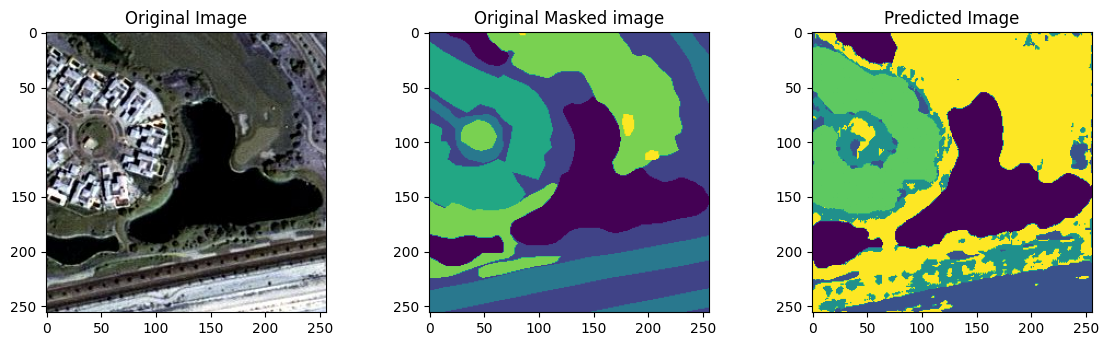

In [61]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
model.save("satellite_segmentation_full.h5")